In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Prepare data for training

In [2]:
training_data = os.listdir('./data/training')
labels = []
for filename in training_data:
    label = filename.split('.')[0]
    if label == 'cat':
        labels.append(0)
    else:
        labels.append(1)

In [3]:
df = pd.DataFrame({
    'name': training_data,
    'labels': labels
})

In [4]:
df.head()

,name,labels
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df.tail()

,name,labels
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


# Prepare data

In [6]:
df['labels'] = df['labels'].replace({0: 'cat', 1: 'dog'})


In [7]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

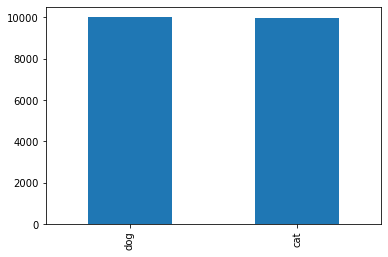

In [8]:
train_df['labels'].value_counts().plot.bar()

# Data Generators

## Training Gen

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./data/training/", 
    x_col='name',
    y_col='labels',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=16
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation Gen

In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./data/training/", 
    x_col='name',
    y_col='labels',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=16
)

Found 5000 validated image filenames belonging to 2 classes.


## See example of generated data

In [11]:
sample_df = train_df.sample(n=1).reset_index(drop=True)
sample_generator = train_datagen.flow_from_dataframe(
    sample_df, 
    "./data/training/",
    x_col='name',
    y_col='labels',
    target_size=(128, 128),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


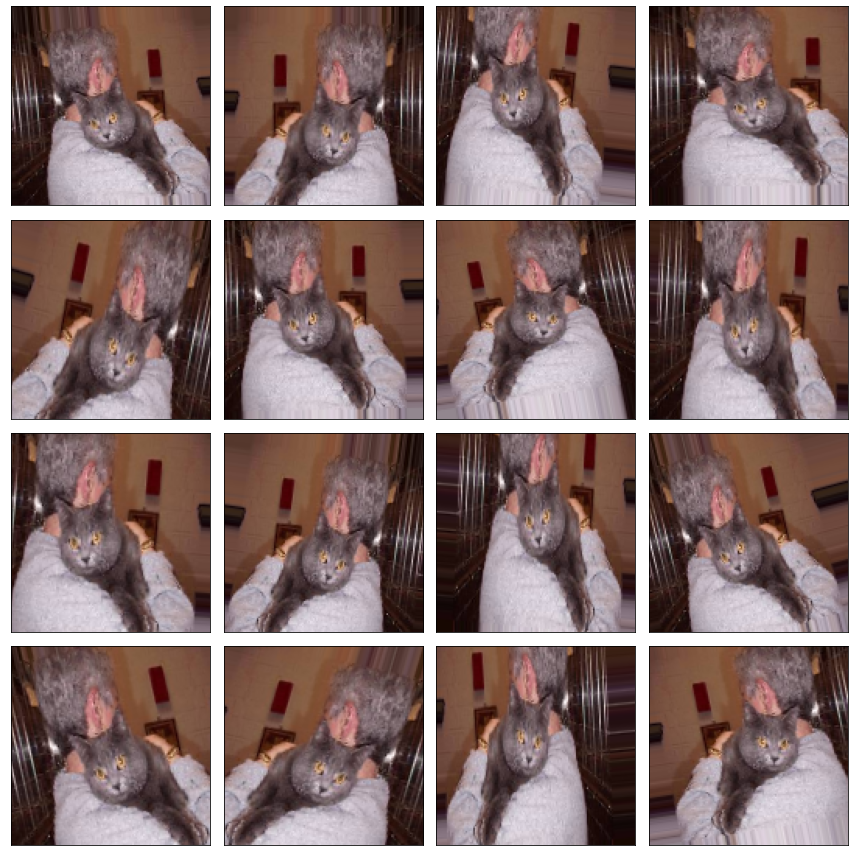

In [12]:
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    for X, Y in sample_generator:
        image = X[0]
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        break
plt.tight_layout()
plt.show()

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Fit model (TRAINING) 

In [27]:
TOTAL_TRAINING_SIZE = train_df.shape[0]
TOTAL_VALIDATION_SIZE = validate_df.shape[0]
BATCH_SIZE = 16
EPOCHS = 50

## Introduce early stopping and handle plateuing

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [29]:
early_stopping = EarlyStopping(patience=10)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        verbose=True,
                                        factor=0.5,
                                        min_lr=1e-5)

In [30]:
from models.cnn_model import CNNModel

model = CNNModel().model

history = model.fit(
            x=train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            validation_steps=TOTAL_VALIDATION_SIZE//BATCH_SIZE,
            steps_per_epoch=TOTAL_TRAINING_SIZE//BATCH_SIZE,
            callbacks=[early_stopping, reduce_learning_rate]
            )

Epoch 1/50
1250/1250 [==============================] - 78s 62ms/step - loss: 0.7108 - accuracy: 0.6398 - val_loss: 1.0518 - val_accuracy: 0.5272 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 77s 62ms/step - loss: 0.5156 - accuracy: 0.7485 - val_loss: 0.4729 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 78s 62ms/step - loss: 0.4461 - accuracy: 0.7933 - val_loss: 0.5102 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 78s 62ms/step - loss: 0.4033 - accuracy: 0.8197 - val_loss: 0.5256 - val_accuracy: 0.7466 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 78s 62ms/step - loss: 0.3653 - accuracy: 0.8392 - val_loss: 0.3106 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 79s 63ms/step - loss: 0.3441 - accuracy: 0.8519 - val_loss: 0.2765 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 7/50
1250/1250 [========================

In [31]:
model.save_weights("model_1.h5")


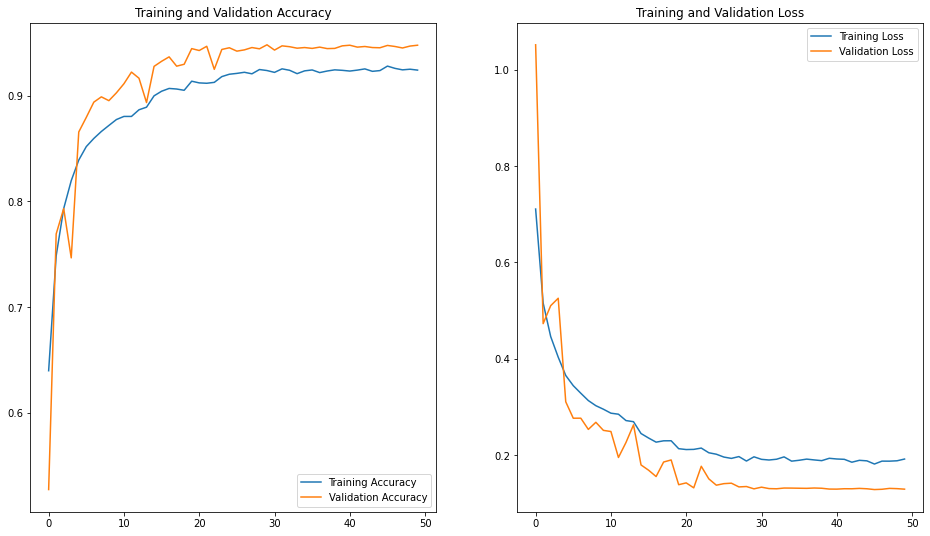

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prepare Testing data

In [60]:
testing_data = os.listdir('./data/testing')
test_df = pd.DataFrame({
    'name': testing_data,
})

nb_samples = test_df.shape[0]

In [67]:
testing_datagen = ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagen.flow_from_dataframe(
    test_df, 
    "./data/testing/", 
    x_col='name',
    y_col=None,
    class_mode=None,
    batch_size=16,
    target_size=(128, 128),
    shuffle=False
)

Found 12500 validated image filenames.


In [68]:
predict = model.predict(testing_generator, steps=np.ceil(nb_samples/16))

In [69]:
test_df['label'] = np.argmax(predict, axis=-1)